In [3]:
import numpy as np
import math
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
from iminuit import Minuit   
from scipy import stats
from scipy.stats import linregress
import sys
import pandas as pd
from astropy.io import fits
# from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from astropy.wcs import WCS
import Annas_functions as func
from spectral_cube import SpectralCube
import astropy.units as u
import seaborn as sns
from matplotlib.lines import Line2D
from astropy.coordinates import SkyCoord

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Cambria'
plt.rcParams['font.size'] = 12

## Definition functions for RMS and S/N , read the file

In [2]:
def rms(intensity):
    return np.sqrt(np.mean(intensity**2))

def sn(signal, noise):
    return signal/noise

In [3]:
hdulist=fits.open(r'C:\Users\anna_\OneDrive\Υπολογιστής\MSc\Thesis\data\i16293\7m\tune_b\member.uid___A001_X362e_X184.IRAS_16293-2422_sci.spw18.cube.I.pbcor.fits')
spectrum=hdulist[0].data[0,:,0,0]
header=hdulist[0].header

dec = hdulist[0].data[0,1017,:,0]
ra = hdulist[0].data[0,1017,0,:]
int_data = hdulist[0].data[0,1017,:,:]

data=hdulist[0].data
header=hdulist[0].header
spectrum=hdulist[0].data[0,0,0,:]

# Extract WCS information
wcs = WCS(header, naxis=2)

# Define the full image region
naxis1 = header['NAXIS1']  # Full image width (RA)
naxis2 = header['NAXIS2']  # Full image height (Dec)


## Select the region of the signal 

<Figure size 1000x800 with 0 Axes>

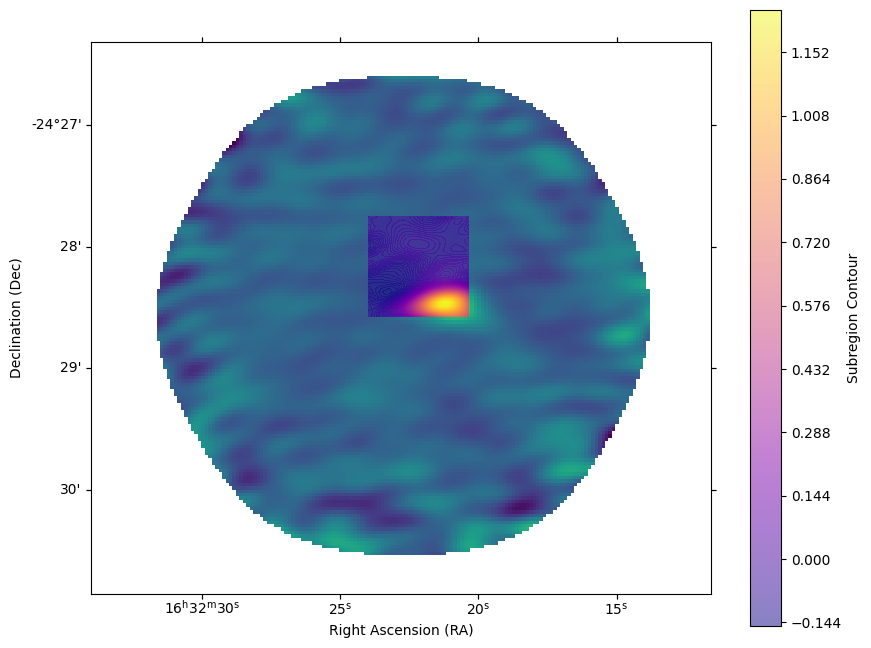

In [4]:
plt.figure(figsize=(10,8))

slice_data_signal = data[0, 756, :, :]

# Define the subregion in pixel coordinates (numpy uses [y, x] so [Dec, RA])
xstart, xend = 80, 110  # RA axis (horizontal)
ystart, yend = 80, 110 # Dec axis (vertical)
subregion_signal = slice_data_signal[ystart:yend, xstart:xend]  # Note: [y, x]

# Plot the full image with WCS projection
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(projection=wcs)

# Display the full image using imshow
im = ax.imshow(slice_data_signal, origin='lower')

# Plot filled contours of the subregion
# The subregion needs to be plotted at the correct pixel positions (so offset it with xstart, ystart)
X, Y = np.meshgrid(np.arange(xstart, xend), np.arange(ystart, yend))  # Create a meshgrid for contour plotting
contour_signal = ax.contourf(X, Y, subregion_signal, 200, origin='lower', cmap='plasma', alpha=0.5)

# Add a colorbar for the contours
plt.colorbar(contour_signal, ax=ax, label='Subregion Contour')

# Set labels for RA and Dec
ax.set_xlabel('Right Ascension (RA)')
ax.set_ylabel('Declination (Dec)')

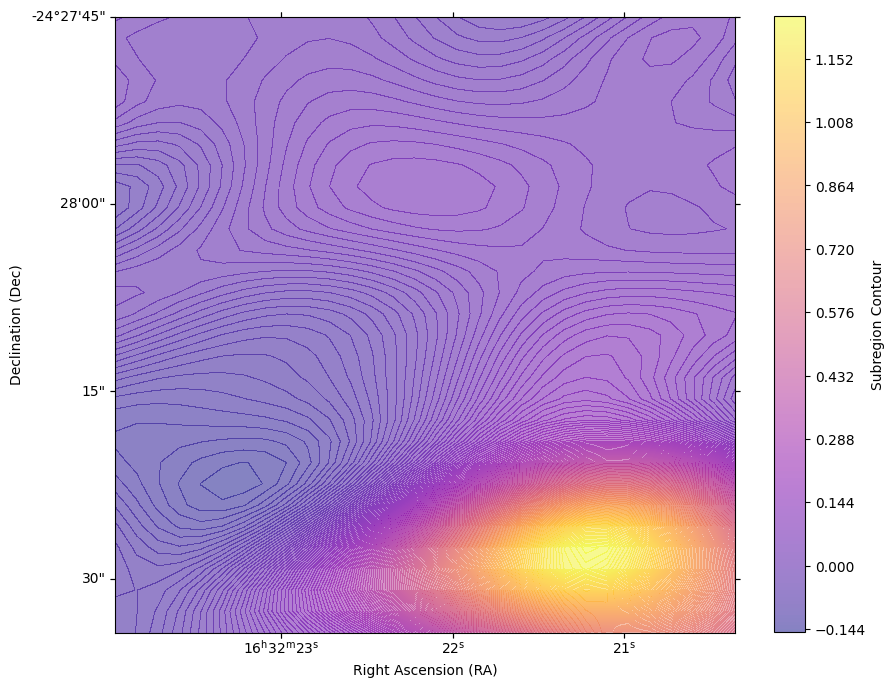

In [5]:
# Plot the full image with WCS projection
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(projection=wcs)

# Plot filled contours of the subregion
# The subregion needs to be plotted at the correct pixel positions (so offset it with xstart, ystart)
X, Y = np.meshgrid(np.arange(xstart, xend), np.arange(ystart, yend))  # Create a meshgrid for contour plotting
contour_signal = ax.contourf(X, Y, subregion_signal, 200, origin='lower', cmap='plasma', alpha=0.5)

plt.colorbar(contour_signal, ax=ax, label='Subregion Contour')

ax.set_xlabel('Right Ascension (RA)')
ax.set_ylabel('Declination (Dec)')

## Select the same region now without signal

<Figure size 1000x800 with 0 Axes>

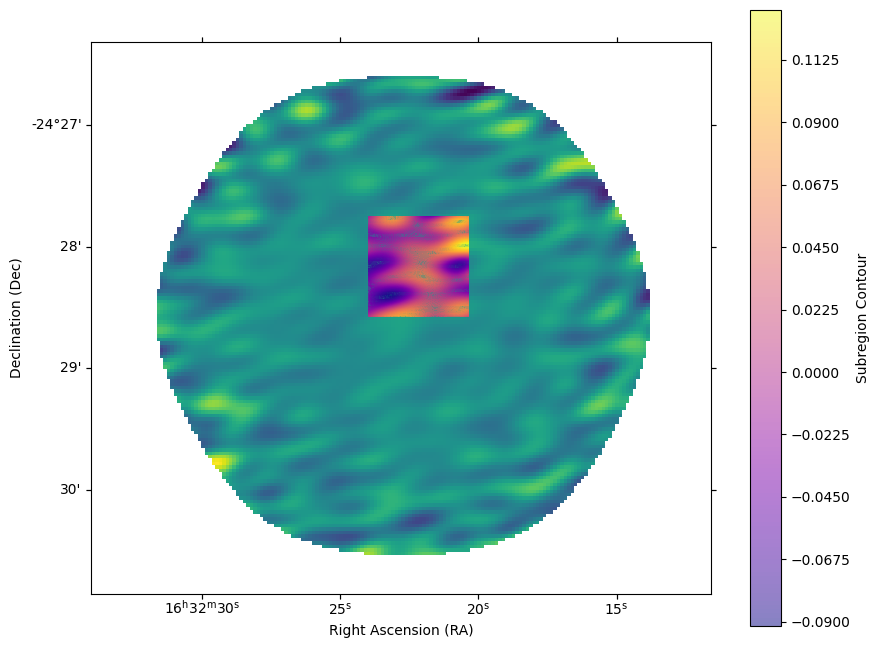

In [6]:
plt.figure(figsize=(10,8))

slice_data_noise = data[0, 477, :, :]

subregion_noise = slice_data_noise[ystart:yend, xstart:xend]  # Note: [y, x]

# Plot the full image with WCS projection
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(projection=wcs)

# Display the full image using imshow
im = ax.imshow(slice_data_noise, origin='lower')

# Plot filled contours of the subregion
# The subregion needs to be plotted at the correct pixel positions (so offset it with xstart, ystart)
X, Y = np.meshgrid(np.arange(xstart, xend), np.arange(ystart, yend))  # Create a meshgrid for contour plotting
contour_noise = ax.contourf(X, Y, subregion_noise, 200, origin='lower', cmap='plasma', alpha=0.5)

# Add a colorbar for the contours
plt.colorbar(contour_noise, ax=ax, label='Subregion Contour')

# Set labels for RA and Dec
ax.set_xlabel('Right Ascension (RA)')
ax.set_ylabel('Declination (Dec)')

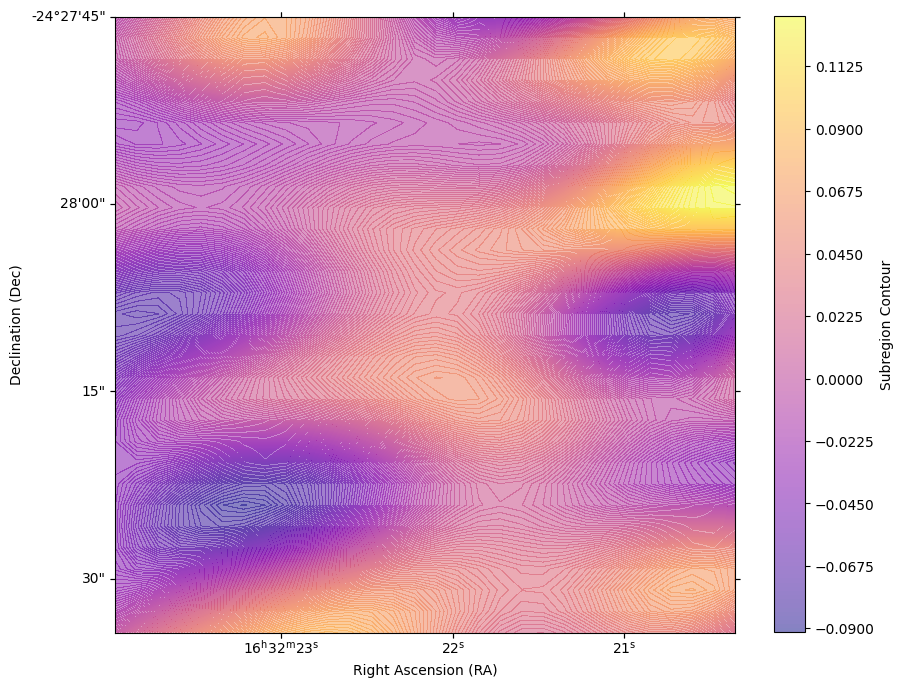

In [7]:
# Plot the full image with WCS projection
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(projection=wcs)

contour_noise = ax.contourf(X, Y, subregion_noise, 200, origin='lower', cmap='plasma', alpha=0.5)

plt.colorbar(contour_noise, ax=ax, label='Subregion Contour')

ax.set_xlabel('Right Ascension (RA)')
ax.set_ylabel('Declination (Dec)')

## Calculation of the RMS

In [8]:
rms_data = rms(subregion_noise)
rms_data

0.042753153

## Calculating the S/N ratio

In [9]:
sn_ratio = sn(subregion_signal, subregion_noise)

print(np.mean(sn_ratio))

7.4392853


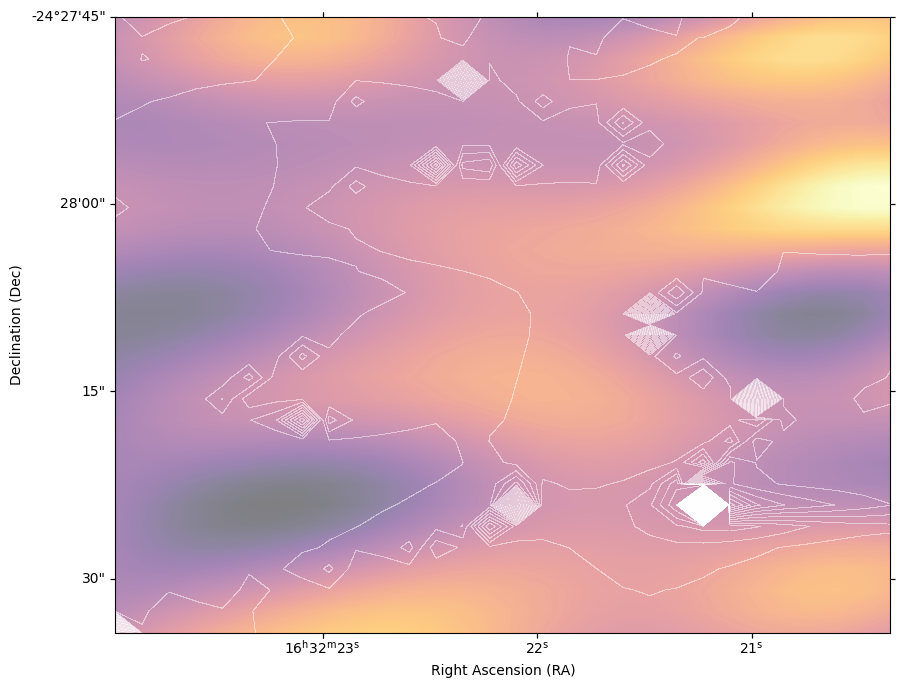

In [10]:
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(projection=wcs)

# ax.contourf(X, Y, subregion_signal, 200, cmap='plasma', alpha=1)
ax.contourf(X, Y, subregion_noise, 200, cmap='inferno', alpha=1)
ax.contourf(X, Y, sn_ratio, 200, colors='white', alpha=0.5)

ax.set_xlabel('Right Ascension (RA)')
ax.set_ylabel('Declination (Dec)')

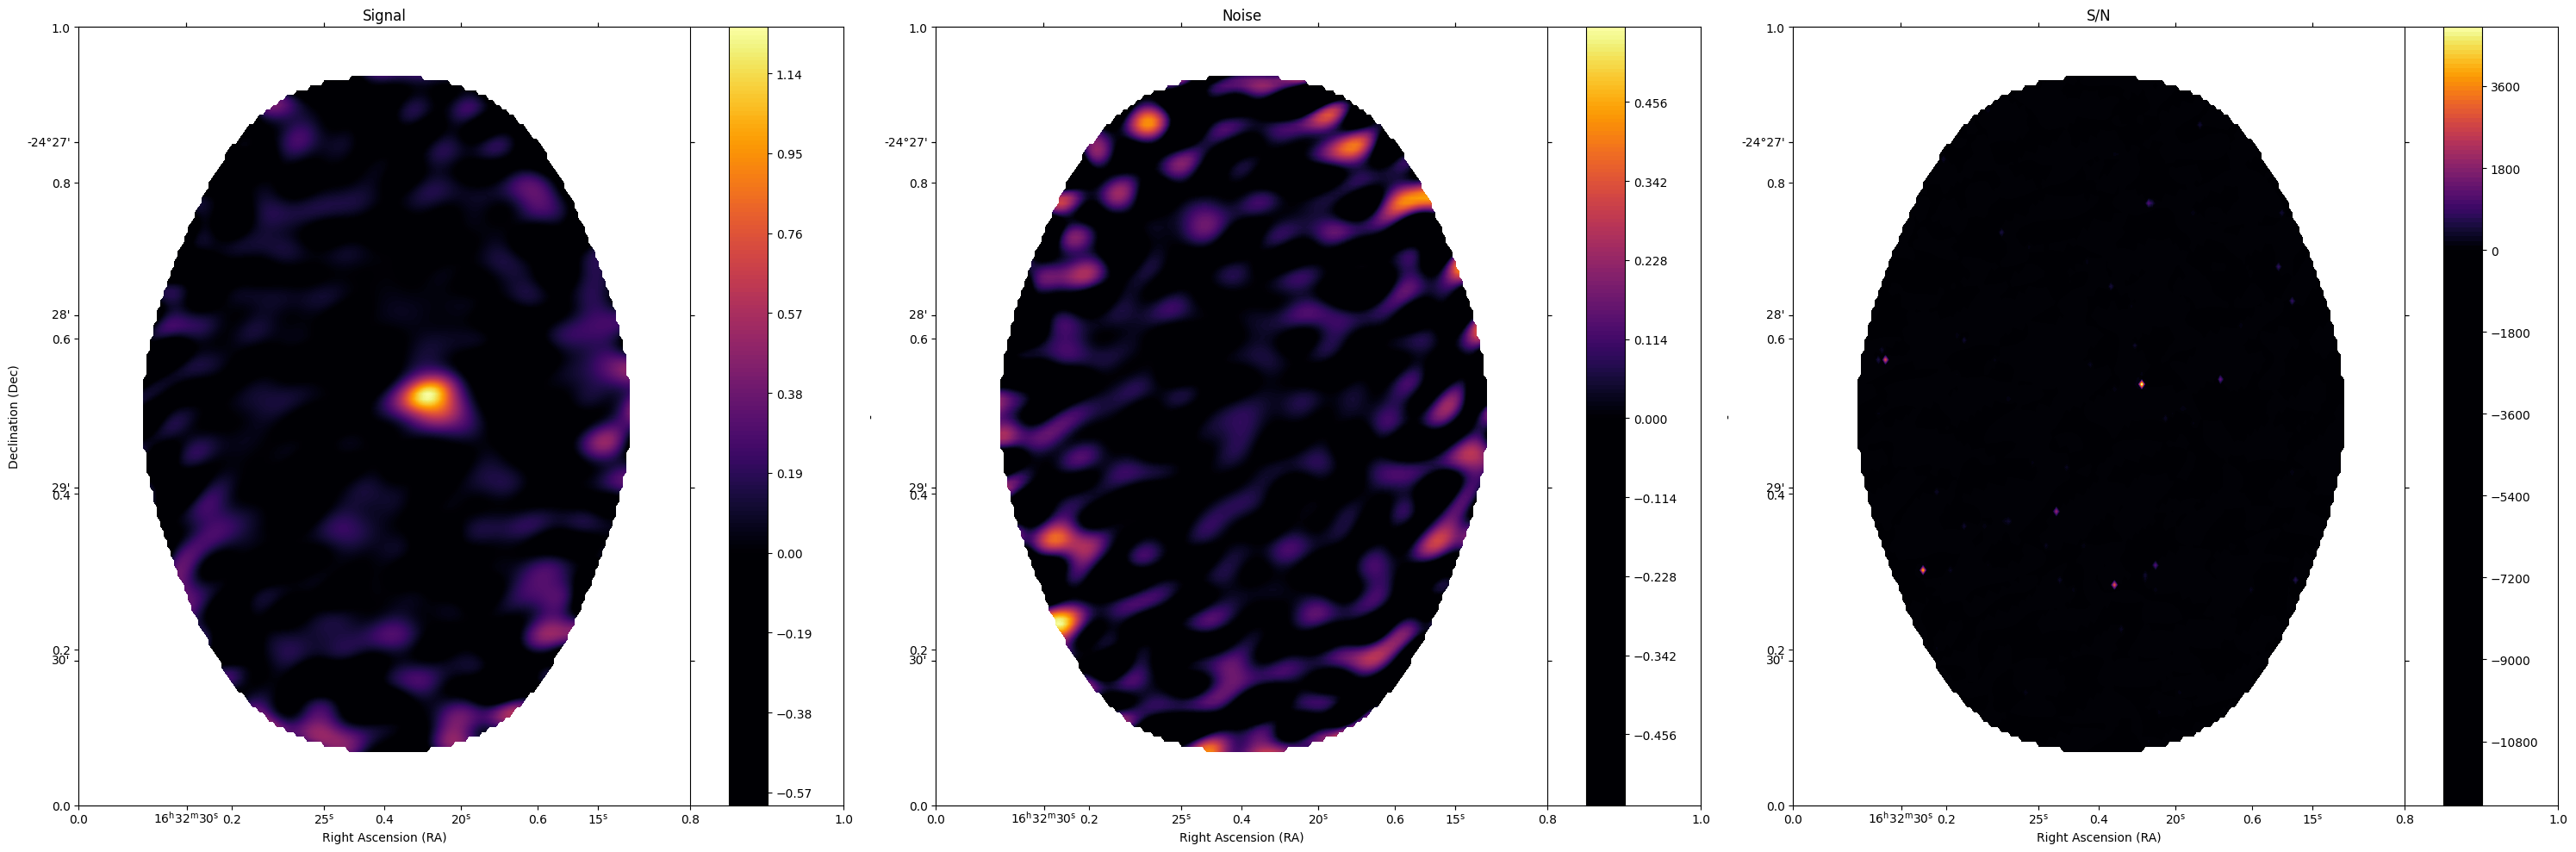

In [11]:
sn_all = sn(slice_data_signal, slice_data_noise)

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
wcs = WCS(header, naxis=2)

axs[0] = plt.subplot(1, 3, 1, projection=wcs)
cmap0 = axs[0].contourf(slice_data_signal, 200, cmap='inferno', alpha=1, vmin=0)
fig.colorbar(cmap0)

axs[1] = plt.subplot(1, 3, 2, projection=wcs)
cmap1 = axs[1].contourf(slice_data_noise, 200, cmap='inferno', alpha=1, vmin=0)
fig.colorbar(cmap1)

axs[2] = plt.subplot(1, 3, 3, projection=wcs)
cmap2 = axs[2].contourf(sn_all, 200, cmap='inferno', alpha=1, vmin=0)
fig.colorbar(cmap2)

axs[0].set_xlabel('Right Ascension (RA)')
axs[0].set_ylabel('Declination (Dec)')
axs[1].set_xlabel('Right Ascension (RA)')
axs[1].set_ylabel('-')
axs[2].set_xlabel('Right Ascension (RA)')
axs[2].set_ylabel('-')

axs[0].set_title('Signal')
axs[1].set_title('Noise')
axs[2].set_title('S/N')


plt.tight_layout()

# Calculation of the S/N when selecting slabs of signal and noise

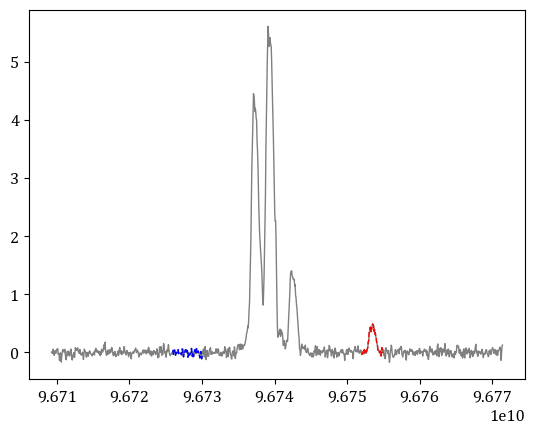

In [72]:
hdulist=fits.open(r'C:\Users\anna_\OneDrive\Υπολογιστής\MSc\Thesis\data\i16293\Combined\tune_b\IRAS_16293-2422_b.spw24.fits')
data_cube = hdulist[0].data
header = hdulist[0].header
wcs = WCS(header, naxis=2)
cube = SpectralCube.read(hdulist)
species = 'CH3OH 2(-1,1)-1(-1,0)E'

f_s_min = 96.752
f_s_max = 96.755
f_n_min = 96.726
f_n_max = 96.73

slab_signal = cube.spectral_slab(f_s_min * u.GHz, f_s_max * u.GHz)
slab_noise = cube.spectral_slab(f_n_min * u.GHz, f_n_max * u.GHz)

i = 86
j = 58

plt.plot(cube.spectral_axis, cube[:, i, j], c='gray', lw=1, linestyle='-', label='Full spectrum')
plt.plot(slab_signal.spectral_axis, slab_signal[:, i, j], c='red', lw=1, linestyle='--', label='Signal region')
plt.plot(slab_noise.spectral_axis, slab_noise[:, i, j], c='blue', lw=1, linestyle='--', label='Noise region')
channels = len(slab_signal.spectral_axis)

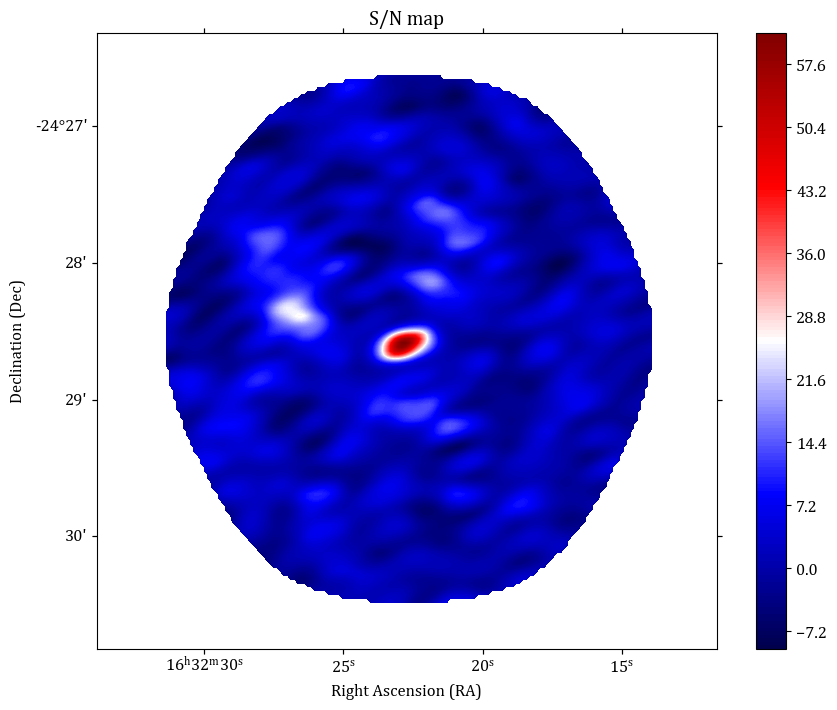

In [73]:
noise = np.nanstd(slab_noise, axis=0)  

rms = np.sqrt(channels* np.nanmean(slab_noise**2, axis=0))

signal = np.nansum(slab_signal, axis=0) 

snr = signal / rms

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(projection=wcs)

snr_map = ax.contourf(snr, 200, cmap='seismic', origin='lower')
fig.colorbar(snr_map)
# rms_map = ax.contourf(rms[660,:,:], 200, cmap='seismic', origin='lower')
# fig.colorbar(rms_map)
plt.title('S/N map')
ax.set_xlabel('Right Ascension (RA)')
ax.set_ylabel('Declination (Dec)')

# plt.savefig(r'C:\Users\anna_\OneDrive\Υπολογιστής\MSc\Thesis\moment maps\snr_map_bspw24_ch3oh(4).pdf', dpi=200)	

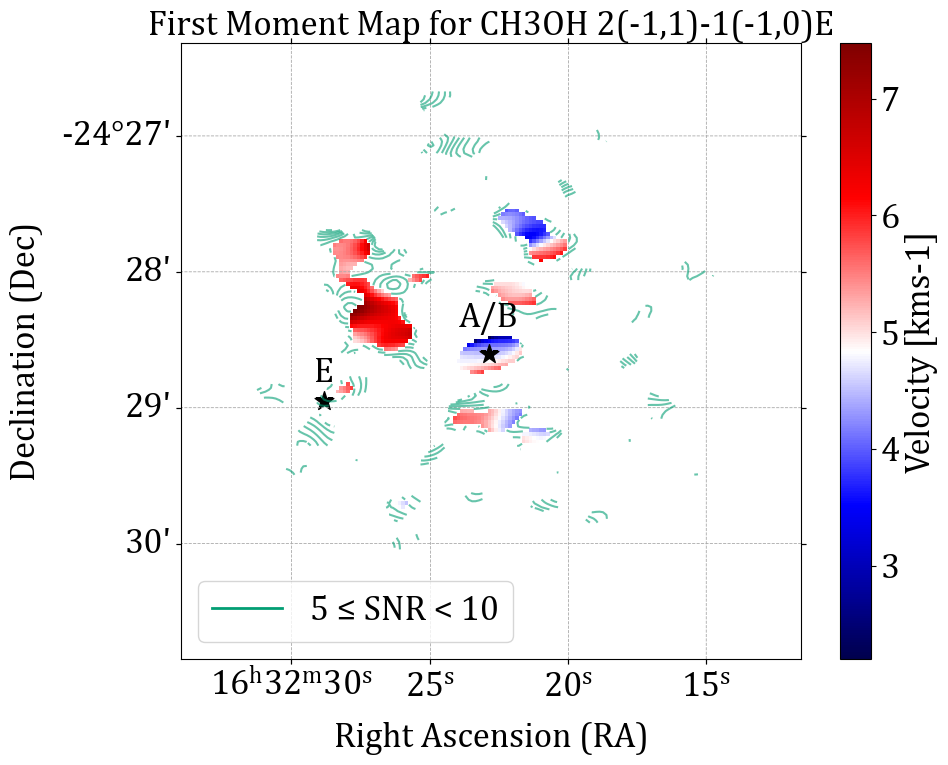

In [ ]:
rest_freq = 96.755501

world_coord_A = SkyCoord('16h32m22.87', '-24d28m36.5s', frame='icrs')
world_coord_E = SkyCoord('16h32m28.84', '-24d28m57s', frame='icrs')

pixel_coord_A = world_coord_A.to_pixel(wcs)
pixel_coord_E = world_coord_E.to_pixel(wcs)

rest_freq = rest_freq * u.GHz
cube_with_velocity = slab_signal.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=rest_freq)
thresholds = [1, 5, 10]
negative = (snr >= -50) & (snr <= -1)
background = (snr < thresholds[0])
low = (snr >= thresholds[0]) & (snr < thresholds[1])
middle = (snr >= thresholds[1]) & (snr < thresholds[2])
snr_mask = snr >= thresholds[2]

cube_negative = cube_with_velocity.with_mask(negative)
cube_masked = cube_with_velocity.with_mask(snr_mask)
cube_background = cube_with_velocity.with_mask(background)
cube_low = cube_with_velocity.with_mask(low)
cube_middle = cube_with_velocity.with_mask(middle)

moment_map = cube_masked.with_spectral_unit(u.km/u.s).moment(order=1)
moment_map_low = cube_low.with_spectral_unit(u.km/u.s).moment(order=1)
moment_map_middle = cube_middle.with_spectral_unit(u.km/u.s).moment(order=1)
moment_map_background = cube_background.with_spectral_unit(u.km/u.s).moment(order=1)
moment_map_negative = cube_negative.with_spectral_unit(u.km/u.s).moment(order=1)

moment_map_1 = moment_map.value  
moment_low = moment_map_low.value
moment_middle = moment_map_middle.value
moment_background = moment_map_background.value
moment_negative = moment_map_negative.value

plt.figure(figsize=(10, 8))
ax = plt.subplot(projection=wcs)

mm1 = ax.imshow(moment_map_1, origin='lower', cmap='seismic', aspect='auto')

cbar = plt.colorbar(mm1, ax=ax, label='Velocity [kms-1]')
cbar.set_label('Velocity [kms-1]', fontsize=25)  # Change the fontsize of the colorbar label
cbar.ax.tick_params(labelsize=25)  # Change the fontsize of the colorbar tick labels

ax.set_title(f'First Moment Map for {species}',  fontsize=25)
ax.set_xlabel('Right Ascension (RA)',  fontsize=25)
ax.set_ylabel('Declination (Dec)',  fontsize=25)

ax.tick_params(axis='both', labelsize=25)
colors = sns.color_palette("colorblind", 10)

# ax.contour(moment_negative, 20, colors=[colors[7]], alpha=0.6)
# ax.contour(moment_background, 20, colors=[colors[7]], alpha=0.6)
# ax.contour(moment_low, 20, colors=[colors[1]], alpha=0.6)
ax.contour(moment_middle, 20, colors=[colors[2]], alpha=0.6)

legend_elements = [
    # Line2D([0], [0], color=colors[7], lw=2, label='SNR < 1'),
    # Line2D([0], [0], color=colors[1], lw=2, label='1 ≤ SNR < 5'),
    Line2D([0], [0], color=colors[2], lw=2, label='5 ≤ SNR < 10')
]

ax.scatter(pixel_coord_A[0], pixel_coord_A[1], color='black', s=200, marker='*')
ax.scatter(pixel_coord_E[0], pixel_coord_E[1], color='black', s=200, marker='*')

ax.text(pixel_coord_A[0], pixel_coord_A[1] + 7, 'A/B', color='black', fontsize=25, ha='center')
ax.text(pixel_coord_E[0], pixel_coord_E[1] + 5, 'E', color='black', fontsize=25, ha='center')

ax.legend(handles=legend_elements, loc='lower left', fontsize=25)
ax.grid(color='darkgray', linestyle='--', linewidth=0.6)
# plt.savefig(r'C:\Users\anna_\OneDrive\Υπολογιστής\MSc\Thesis\results\i16293\moment maps\mm1\final_mm1_ch3oh 2(-1,1)-1(-1,0)E.pdf', dpi=200, bbox_inches='tight')